In [1]:
import numpy as np
import nengo
from nengo.dists import Choice, Uniform
from nengo.solvers import NoSolver
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette('deep', 6)
sns.set(style='white', context='poster', palette='deep')

In [2]:
def make_US_CS_arrays(pairings=3, dt=0.001, seed=0):  # times measured in seconds
    rng = np.random.RandomState(seed=seed)
    pt = 2  # empty time pre-tone
    tt = 3  # tone time
    ps = 4  # empty time pre-shock
    st = 1  # shock time
    wt = 5  # delay time
    at = 5  # active time
    assert at == pt+tt == ps+st, "stimulus times unaligned"
    CS_array = np.zeros((int(pairings*(wt+at)/dt))*2)
    US_array = np.zeros((int(pairings*(wt+at)/dt))*2)
    for i in range(pairings):
        CS_array[int(i*(wt+at)/dt) : int((i*(wt+at)+pt)/dt)] = 0  # nothing
        US_array[int(i*(wt+at)/dt) : int((i*(wt+at)+ps)/dt)] = 0  # nothing
        CS_array[int((i*(wt+at)+pt)/dt) : int((i*(wt+at)+pt+tt)/dt)] = 1  # tone
        US_array[int((i*(wt+at)+ps)/dt) : int((i*(wt+at)+ps+st)/dt)] = 1  # shock
        CS_array[int((i*(wt+at)+at)/dt) : int(i*(wt+at)+(wt+at)/dt)] = 0  # delay
        US_array[int((i*(wt+at)+at)/dt) : int(i*(wt+at)+(wt+at)/dt)] = 0  # delay
    return CS_array, US_array

In [3]:
def go(t, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, seed=0, learning=True,
       musc_CeL_func=lambda t: 0,
       musc_BLA_func=lambda t: 0,
       oxy_CeL_func=0.5,
       vaso_CeM_func=lambda t: 0.5,
       BLA_func=lambda t: 0.5):
    
    model = nengo.Network(seed=seed)
    model.config[nengo.Connection].synapse = 0.02
    model.config[nengo.Probe].synapse = 0.02
    with model:
        # Nodes
        tone_inpt = nengo.Node(tone_func)  # CS input
        shock_inpt = nengo.Node(shock_func)  # US input
        context_inpt = nengo.Node(context_func)
        motor_inpt = nengo.Node(1)  # default excitation of PAG neurons, causing movement
        
        # Ensembles
        # outside amydgala
        thalamus = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='thalamus')
        auditory_cortex = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='auditory cortex')
        sensory_cortex = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='sensory_cortex')
        spinal_cord = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='spinal cord')
        hippocampus = nengo.Ensemble(400, 2, encoders=Choice([[1, 0], [0, 1], [-1, 0], [0, -1]]), radius=np.sqrt(2), label='hippocampus')
        PAG = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='PAG')  # [move]
        # central amygdala
        CeL = nengo.Ensemble(400, 2, encoders=Choice([[1, 0], [0, 1], [-1, 0], [0, -1]]), radius=np.sqrt(2), label='CeL')  # [tone, shock]
        CeL_off = nengo.Ensemble(400, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='CeL_off')  # [move]
        CeM = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='CeM')  # [freeze]
        error_CeL_pos = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_CeL_pos')
        error_CeL_neg = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_CeL_neg')
        # basolateral amygdala
        BLA = nengo.Ensemble(600, 3, label='BA')  # [tone, shock, context]
        error_tone = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_tone')
        error_context_pos = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_context_pos')
        error_context_neg = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_context_neg')
        BLA_interneuron = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='BLA_interneuron')
        
        # Connections
        # inputs and outputs
        nengo.Connection(tone_inpt, thalamus)
        nengo.Connection(shock_inpt, spinal_cord)
        nengo.Connection(tone_inpt, auditory_cortex)
        nengo.Connection(shock_inpt, sensory_cortex)
        nengo.Connection(context_inpt, hippocampus)
        nengo.Connection(motor_inpt, PAG)
        # central amygdala
        thal_CeL = nengo.Connection(thalamus, CeL[0], solver=NoSolver(d_thal_CeL), learning_rule_type=nengo.PES(2e-6*learning))  # learning tone-fear
        nengo.Connection(spinal_cord, CeL[1])
        nengo.Connection(CeL[0], CeL_off.neurons, transform=-np.ones((CeL_off.n_neurons, 1)))  # activate freezing via dis-dis-inhibition
#         nengo.Connection(CeL[1], CeL_off.neurons, transform=-np.ones((CeL_off.n_neurons, 1)))  # activate freezing via dis-dis-inhibition
        nengo.Connection(CeL_off, CeM.neurons, transform=-np.ones((CeM.n_neurons, 1)))  # inhibit default freezing
        nengo.Connection(CeL, error_CeL_pos, function=lambda x: x[1]-x[0])  # error signal, shock - tone (reversed below)
        nengo.Connection(CeL, error_CeL_neg, function=lambda x: x[0]-x[1])  # error signal, tone - shock
        nengo.Connection(error_CeL_pos, thal_CeL.learning_rule, transform=-1)
        nengo.Connection(error_CeL_neg, thal_CeL.learning_rule, transform=0.1)
        nengo.Connection(CeM, PAG.neurons, transform=-np.ones((PAG.n_neurons, 1)))
        # basolateral amygdala
        cortex_BLA = nengo.Connection(auditory_cortex, BLA[0], solver=NoSolver(d_cortex_BLA), learning_rule_type=nengo.PES(6e-6*learning))  # learning tone-fear
        nengo.Connection(sensory_cortex, BLA[1])
        hippo_BLA = nengo.Connection(hippocampus.neurons, BLA[2], transform=d_hippo_BLA.T, learning_rule_type=nengo.PES(6e-6*learning))  # learning context-fear/extinct
        nengo.Connection(BLA, error_tone, function=lambda x: x[1]-x[0])  # error signal, shock - tone (reversed below)
        nengo.Connection(BLA, error_context_pos, function=lambda x: x[1]-x[2])  # error = shock - tone (reversed below)
        nengo.Connection(BLA, error_context_neg, function=lambda x: x[0]-x[1])  # error = tone - shock
        nengo.Connection(error_tone, cortex_BLA.learning_rule, transform=-1)  # error = tone - shock
        nengo.Connection(error_context_pos, hippo_BLA.learning_rule, transform=-3)  # context-fear association, error = tone - shock
        nengo.Connection(error_context_neg, hippo_BLA.learning_rule, transform=3)  # context-extinct association, smaller learning rate than context-fear
        nengo.Connection(BLA_interneuron, BLA.neurons, transform=-0.75*np.ones((BLA.n_neurons, 1)))  # GABAergic inhibition
        nengo.Connection(BLA_interneuron, error_tone.neurons, transform=-0.5*np.ones((error_tone.n_neurons, 1)))  # GABAergic inhibition
        nengo.Connection(BLA_interneuron, error_context_pos.neurons, transform=-0.5*np.ones((error_context_pos.n_neurons, 1)))  # GABAergic inhibition
        nengo.Connection(BLA_interneuron, error_context_neg.neurons, transform=-0.5*np.ones((error_context_neg.n_neurons, 1)))  # GABAergic inhibition
        nengo.Connection(BLA, CeM, function=lambda x: 0.5*x[0]+1.5*x[2]) # combination of tone and context response
#         nengo.Connection(BLA, CeM, function=lambda x: 0.5*x[1]) # shock response

        # Pharmacology
        CeL_inpt = nengo.Node(musc_CeL_func)  # pharmacological inactivation (muscimol)
        CeL_off_inpt = nengo.Node(oxy_CeL_func)  # default excitation of CeL neurons that inhibit CeM, maintaining movement via disinhibition (oxytocin)
        CeM_inpt = nengo.Node(vaso_CeM_func)  # default excitation of CeM neurons, causing default freezing (vasopressin)
        BLA_inpt = nengo.Node(BLA_func)  # pharmacological activation (dopamine or norepinephrine), or inactivation (seratonin) of GABA interneurons
        musc_BLA_inpt = nengo.Node(musc_BLA_func)  # pharmacological inactivation (muscimol)
        nengo.Connection(CeL_inpt, CeL.neurons, transform=np.ones((CeL.n_neurons, 1)))
        nengo.Connection(CeL_inpt, CeL_off.neurons, transform=np.ones((CeL_off.n_neurons, 1)))
        nengo.Connection(CeL_inpt, error_CeL_pos.neurons, transform=np.ones((error_CeL_pos.n_neurons, 1)))
        nengo.Connection(CeL_inpt, error_CeL_neg.neurons, transform=np.ones((error_CeL_neg.n_neurons, 1)))
        nengo.Connection(CeL_off_inpt, CeL_off.neurons, transform=np.ones((CeL_off.n_neurons, 1)))
        nengo.Connection(CeM_inpt, CeM.neurons, transform=np.ones((CeM.n_neurons, 1)))
        nengo.Connection(BLA_inpt, BLA_interneuron)
        nengo.Connection(musc_BLA_inpt, BLA.neurons, transform=np.ones((BLA.n_neurons, 1)))
        nengo.Connection(musc_BLA_inpt, error_tone.neurons, transform=np.ones((error_tone.n_neurons, 1)))
        nengo.Connection(musc_BLA_inpt, error_context_pos.neurons, transform=np.ones((error_context_pos.n_neurons, 1)))
        nengo.Connection(musc_BLA_inpt, error_context_neg.neurons, transform=np.ones((error_context_neg.n_neurons, 1)))
        
        # Probes
        p_thalamus = nengo.Probe(thalamus)
        p_spinal_cord = nengo.Probe(spinal_cord)
        p_auditory_cortex = nengo.Probe(auditory_cortex)
        p_sensory_cortex = nengo.Probe(sensory_cortex)
        p_CeL = nengo.Probe(CeL)  
        p_CeL_off = nengo.Probe(CeL_off)
        p_CeM = nengo.Probe(CeM)
        p_BLA = nengo.Probe(BLA)
        p_BLA_interneuron = nengo.Probe(BLA_interneuron)
        p_PAG = nengo.Probe(PAG)
        p_error_CeL_pos = nengo.Probe(error_CeL_pos)
        p_error_CeL_neg = nengo.Probe(error_CeL_neg)
        p_error_tone = nengo.Probe(error_tone)
        p_error_context_pos = nengo.Probe(error_context_pos)
        p_error_context_neg = nengo.Probe(error_context_neg)
        p_thal_CeL = nengo.Probe(thal_CeL, 'weights', synapse=None)
        p_cortex_BLA = nengo.Probe(cortex_BLA, 'weights', synapse=None)
        p_hippo_BLA = nengo.Probe(hippo_BLA, 'weights', synapse=None)
        
    sim = nengo.Simulator(model, progress_bar=False, seed=seed)
    with sim:
        sim.run(t, progress_bar=True)
        
    return dict(
        times = sim.trange(),
        thalamus = sim.data[p_thalamus],
        spinal_cord = sim.data[p_spinal_cord],
        auditory_cortex = sim.data[p_auditory_cortex],
        sensory_cortex = sim.data[p_sensory_cortex],
        CeL = sim.data[p_CeL],
        CeL_off = sim.data[p_CeL_off],
        BLA = sim.data[p_BLA],
        BLA_interneuron = sim.data[p_BLA_interneuron],
        CeM = sim.data[p_CeM],
        PAG = sim.data[p_PAG],
        error_CeL_pos = sim.data[p_error_CeL_pos],
        error_CeL_neg = sim.data[p_error_CeL_neg],
        error_tone = sim.data[p_error_tone],
        error_context_pos = sim.data[p_error_context_pos],
        error_context_neg = sim.data[p_error_context_neg],
        thal_CeL = sim.data[p_thal_CeL][-1].T,
        cortex_BLA = sim.data[p_cortex_BLA][-1].T,
        hippo_BLA = sim.data[p_hippo_BLA][-1].T,
    )

# Simulations

### poster plot

In [4]:
seed = 0
t_condition = 30
t_test = 4
dt = 0.001
tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
tone_func = lambda t: tones[int(t/dt)]
shock_func = lambda t: shocks[int(t/dt)]
context_func = lambda t: [1, 0]
d_thal_CeL = np.zeros((200, 1))
d_cortex_BLA = np.zeros((200, 1))
d_hippo_BLA = np.zeros((400, 1))

data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
    seed=seed)

d_thal_CeL = data['thal_CeL']
d_cortex_BLA = data['cortex_BLA']
d_hippo_BLA = data['hippo_BLA']

tone_func = lambda t: 0 if (0<t<2) else 1
shock_func = lambda t: 0
context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

data2 = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
    seed=seed, learning=False)

/home/pduggins/.local/share/virtualenvs/anatomical_amygdala--T40zd3z/lib/python3.7/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

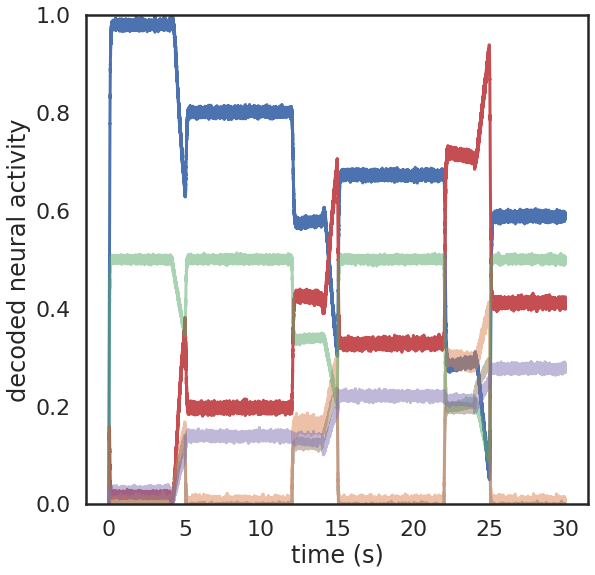

In [5]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[5])
ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
ax.set(xlabel='time (s)', ylabel='decoded neural activity', ylim=((0, 1)))
plt.savefig('plots/poster_train.svg')
# ax.legend()
plt.show()

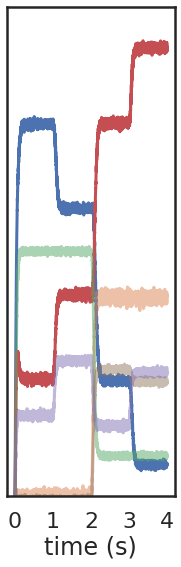

In [6]:
fig, ax = plt.subplots(figsize=(3, 9))
ax.plot(data2['times'], data2['PAG'], label='PAG', color=palette[0])
ax.plot(data2['times'], data2['CeM'], label='CeM', color=palette[3])
ax.plot(data2['times'], data2['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
ax.plot(data2['times'], data2['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
ax.plot(data2['times'], data2['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[5])
ax.plot(data2['times'], data2['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
ax.set(xlabel='time (s)', xticks=((0, 1, 2, 3, 4)), yticks=(()), ylim=((0, 1)))
plt.savefig('plots/poster_test.svg')
# ax.legend()
plt.show()

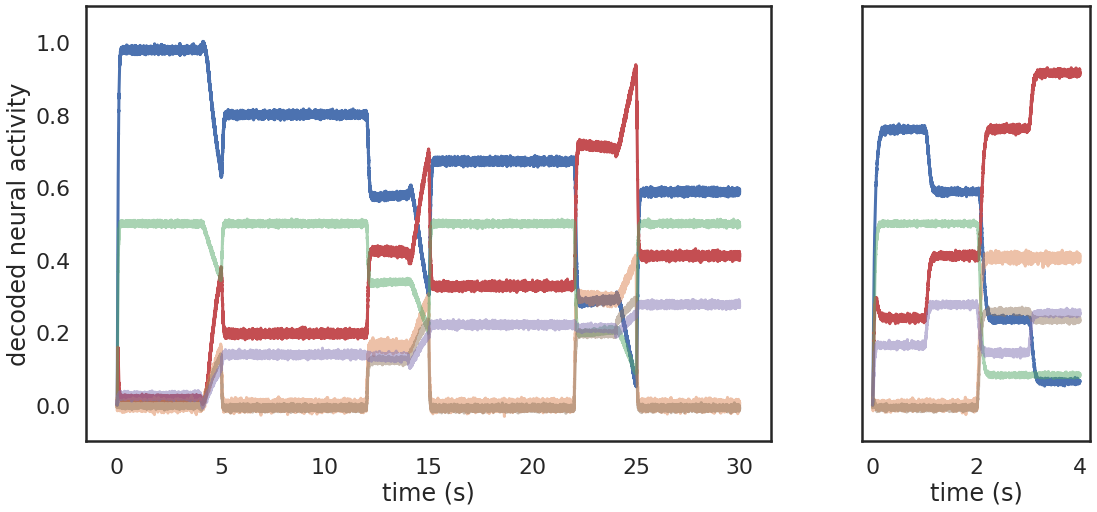

In [7]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[5])
ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
ax.set(xlabel='time (s)', ylabel='decoded neural activity', ylim=((-0.1, 1.1)))
ax2.plot(data2['times'], data2['PAG'], label='PAG', color=palette[0])
ax2.plot(data2['times'], data2['CeM'], label='CeM', color=palette[3])
ax2.plot(data2['times'], data2['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
ax2.plot(data2['times'], data2['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
ax2.plot(data2['times'], data2['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[5])
ax2.plot(data2['times'], data2['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
ax2.set(xlabel='time (s)', ylim=((-0.1, 1.1)))
plt.savefig('plots/poster_together.svg')
# plt.legend()
plt.show()

## Controls

In [8]:
def pre_control(seed=0, plot=True):

    t_test = 4
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]
    
    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed, learning=False)
    
    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel='neural activity', ylim=((-0.1, 1.1)))
        ax.legend()
        plt.savefig('plots/pre_control.svg')
        plt.show()
        
    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

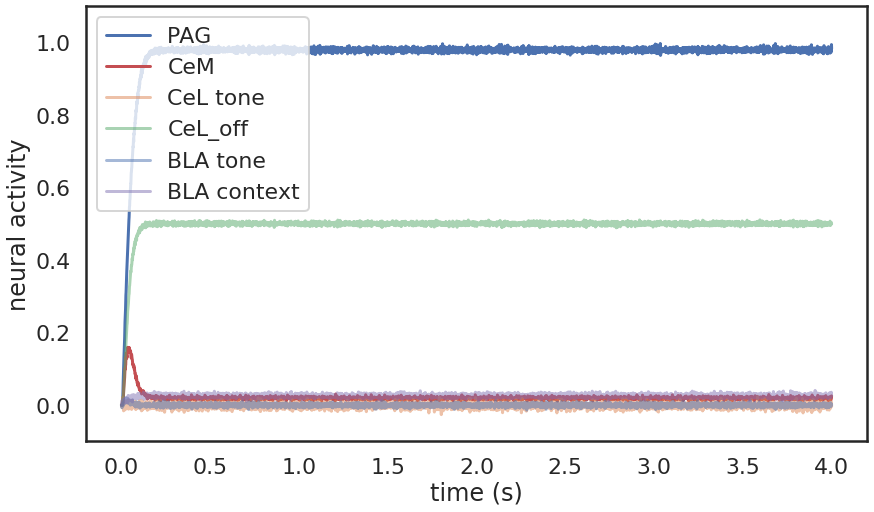

In [9]:
A = pre_control()

In [10]:
def condition_control(seed=0, plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel='neural activity', ylim=((-0.1, 1.1)))
        plt.savefig('plots/condition_control_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel='neural activity', ylim=((-0.1, 1.1)))
        plt.savefig('plots/condition_control_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

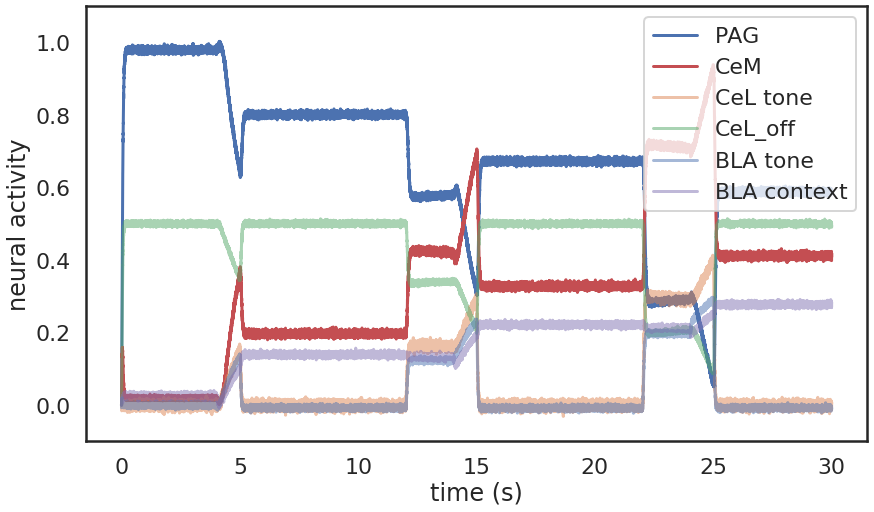

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

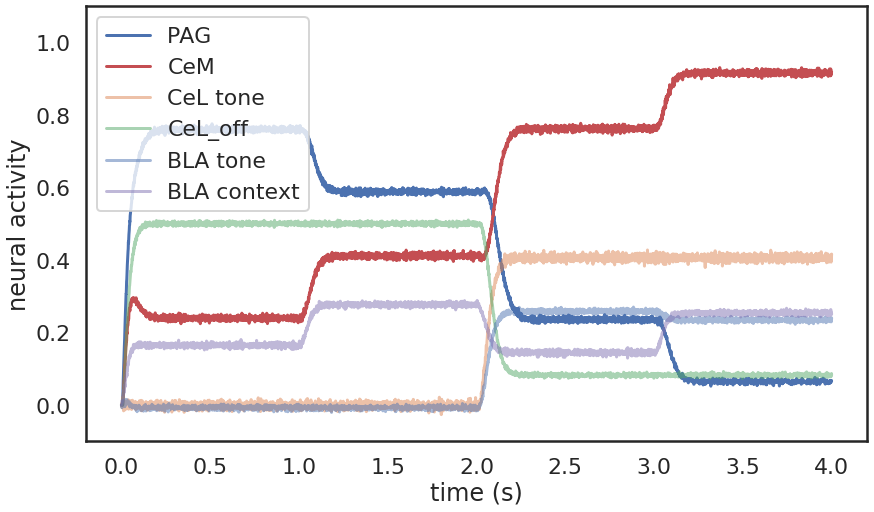

In [11]:
B = condition_control()

In [12]:
def extinction_control(seed=0, plot=True):

    t_condition = 30
    t_extinct = 100
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel='neural activity', ylim=((-0.1, 1.1)))
        plt.savefig('plots/extinction_control_train.svg')
        ax.legend()
        plt.show()

    tones, shocks = make_US_CS_arrays(pairings=1+int(t_extinct/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1]

    data = go(t_extinct, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel='neural activity', ylim=((-0.1, 1.1)))
        plt.savefig('plots/extinction_control_train2.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.3, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.3, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.3, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.3, color=palette[4])
        ax.set(xlabel='time (s)', ylabel='neural activity', ylim=((-0.1, 1.1)))
        plt.savefig('plots/extinction_control_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

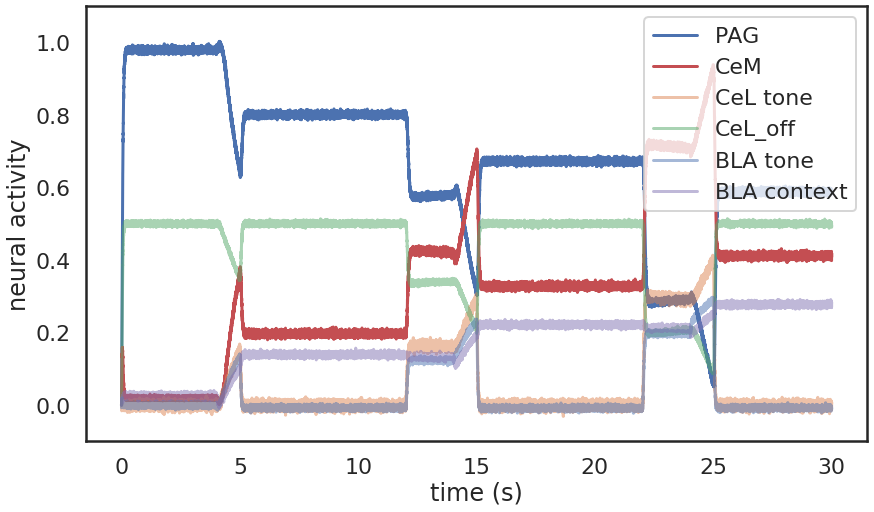

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/pduggins/.local/share/virtualenvs/anatomical_amygdala--T40zd3z/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


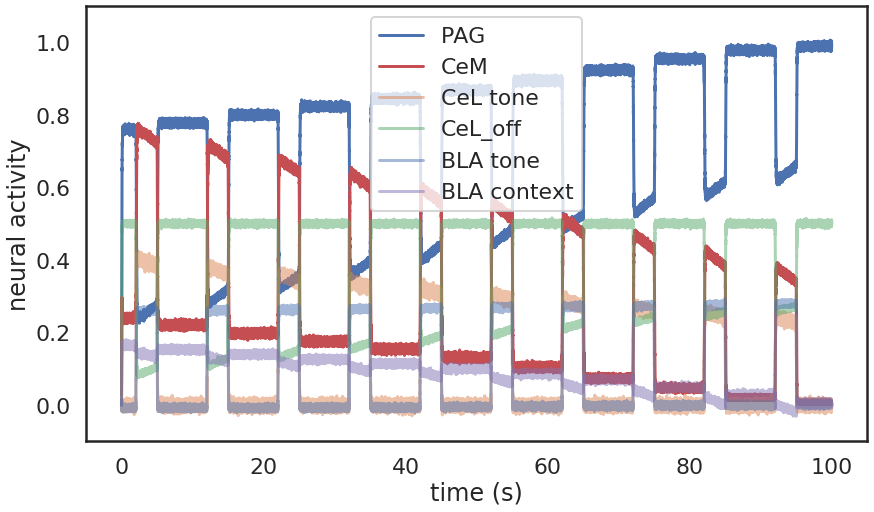

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

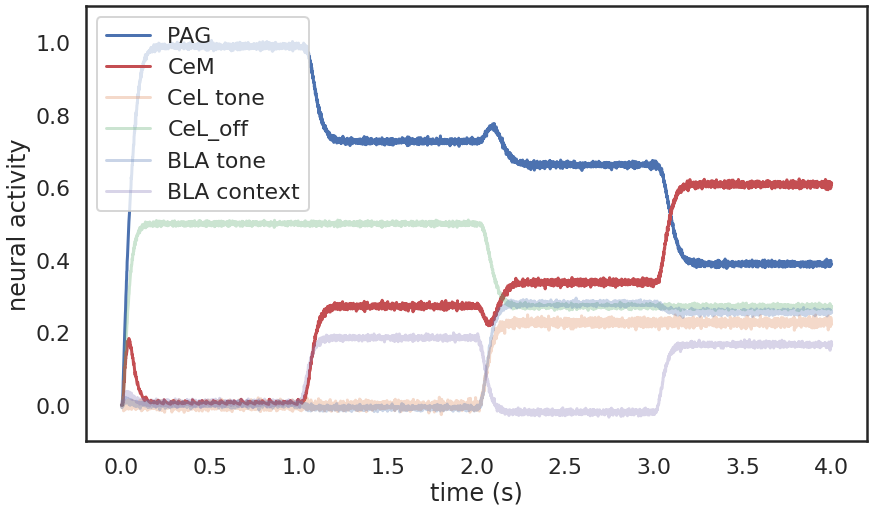

In [13]:
C = extinction_control()

## Muscimol

### Inctivation of CeL induces spontaneous freezing (Ciocchi et al, 2010)
GABA_A receptor agonist (muscimol-bodipy (BPY)) applied to CeL alone induced spontaneous freezing

In [14]:
def pre_muscimol_CeL(seed=0, plot=True):

    t_test = 4
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]
    musc_CeL_func = lambda t: -1

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, musc_CeL_func=musc_CeL_func,
        seed=seed, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel='neural activity', ylim=((-0.1, 1.1)))
        ax.legend()
        plt.savefig('plots/pre_muscimol_CeL.svg')
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

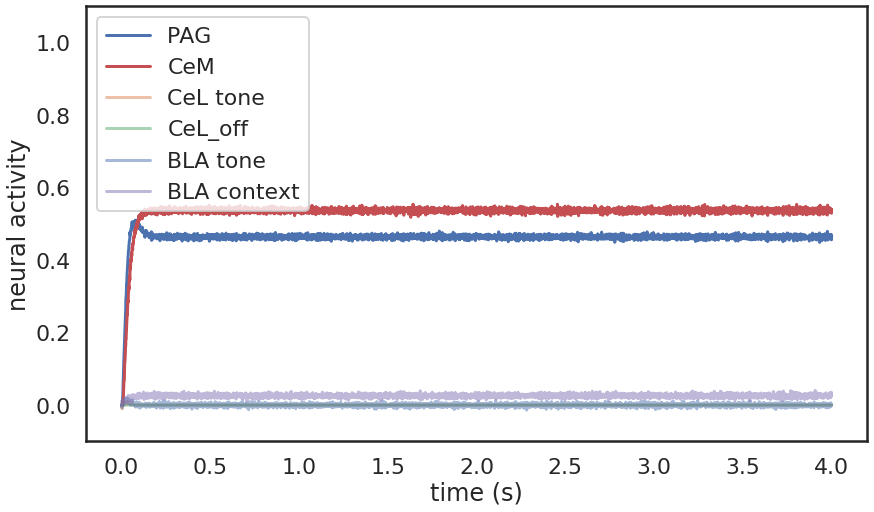

In [15]:
D = pre_muscimol_CeL()

### Inactivation of CeL during training impairs fear conditioning (Ciocchi et al., 2010)

In [16]:
def muscimol_CeL_condition(seed=0, plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    musc_CeL_func = lambda t: -1

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, musc_CeL_func=musc_CeL_func,
        seed=seed)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/muscimol_CeL_condition_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.3, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.3, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.3, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.3, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/muscimol_CeL_condition_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

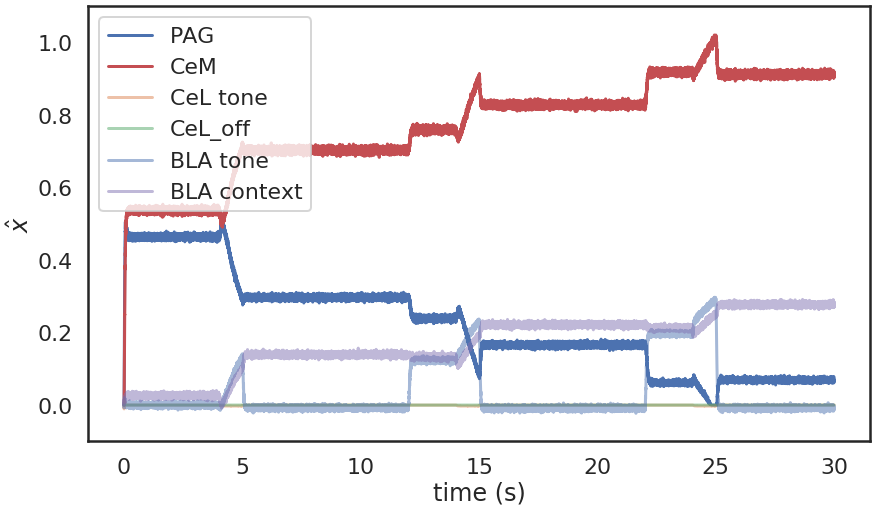

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

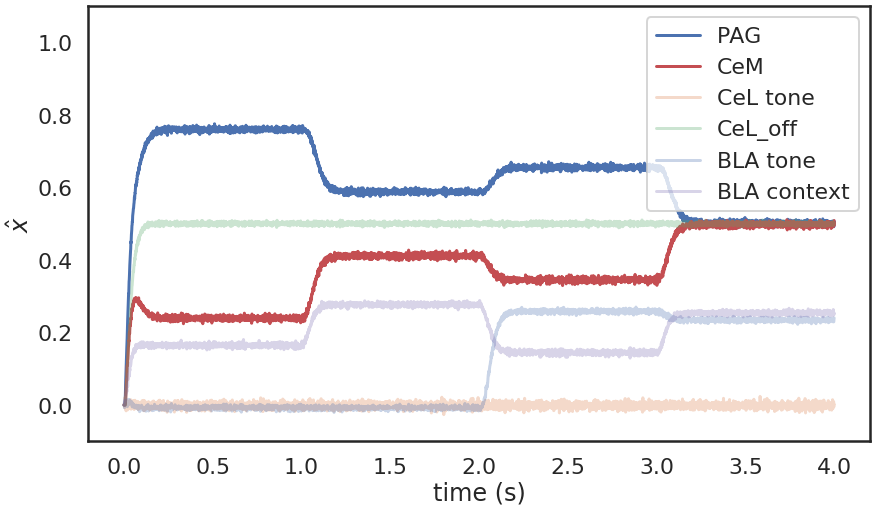

In [17]:
E = muscimol_CeL_condition()

### Inactivation of BLA impairs fear conditioning (Muller et al. 1997).

In [18]:
def muscimol_BLA_condition(seed=0, plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    musc_BLA_func = lambda t: -1.0

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, musc_BLA_func=musc_BLA_func,
        seed=seed)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/muscimol_BLA_condition_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/muscimol_BLA_condition_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

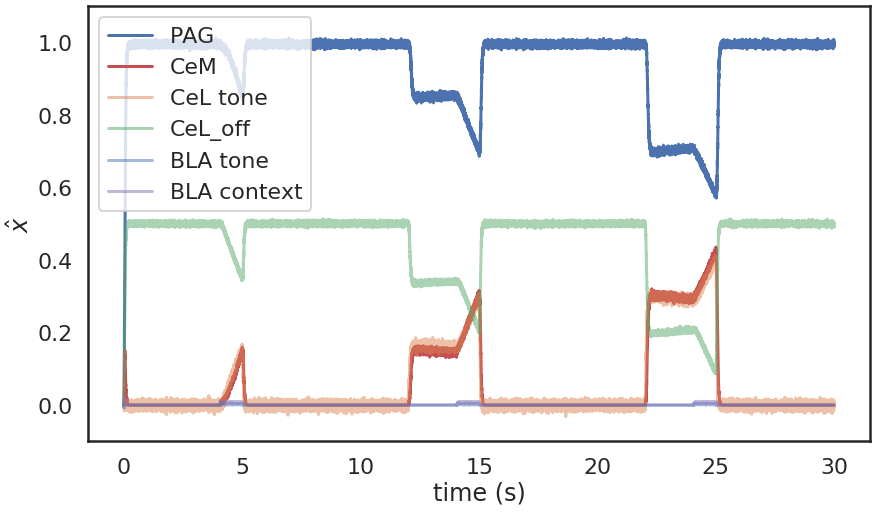

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

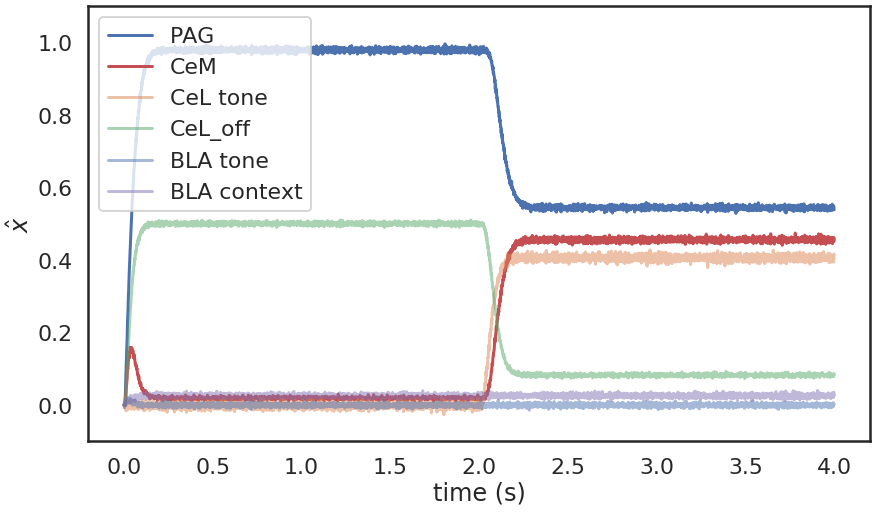

In [19]:
F = muscimol_BLA_condition()

### Inactivation of BLA impairs extinction (Sierra-Mercado et al., 2011 vs. Amano et al., 2009)

In [20]:
def muscimol_BLA_extinction(seed=0, plot=True):

    t_condition = 30
    t_extinct = 100
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/muscimol_BLA_extinction_train.svg')
        ax.legend()
        plt.show()

    tones, shocks = make_US_CS_arrays(pairings=1+int(t_extinct/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1]
    musc_BLA_func = lambda t: -1

    data = go(t_extinct, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, musc_BLA_func=musc_BLA_func,
        seed=seed)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/muscimol_BLA_extinction_train2.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.3, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.3, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.3, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.3, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/muscimol_BLA_extinction_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

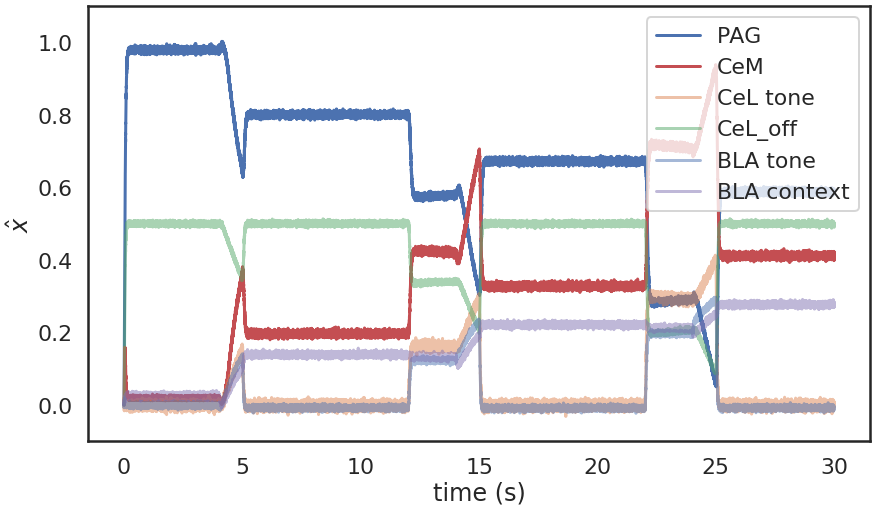

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

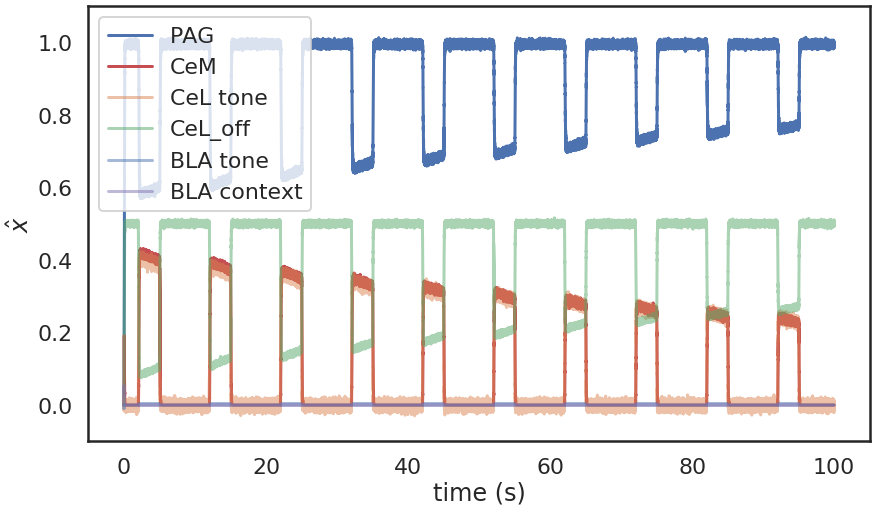

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

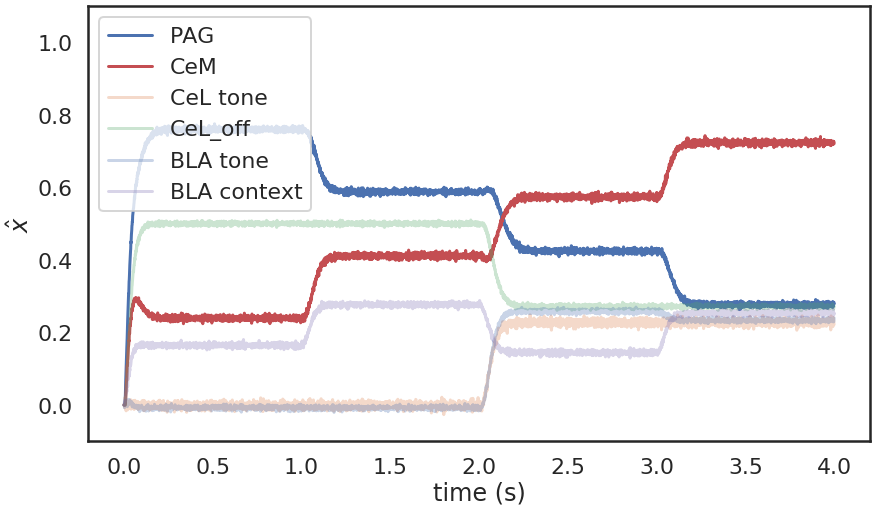

In [21]:
G = muscimol_BLA_extinction()

### Inactivation of BLA impairs fear expression (Muller et al. 1997).

In [22]:
def condition_muscimol_BLA(seed=0, plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/condition_muscimol_BLA_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]
    musc_BLA_func = lambda t: -1.0

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, musc_BLA_func=musc_BLA_func,
        seed=seed, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/condition_muscimol_BLA_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

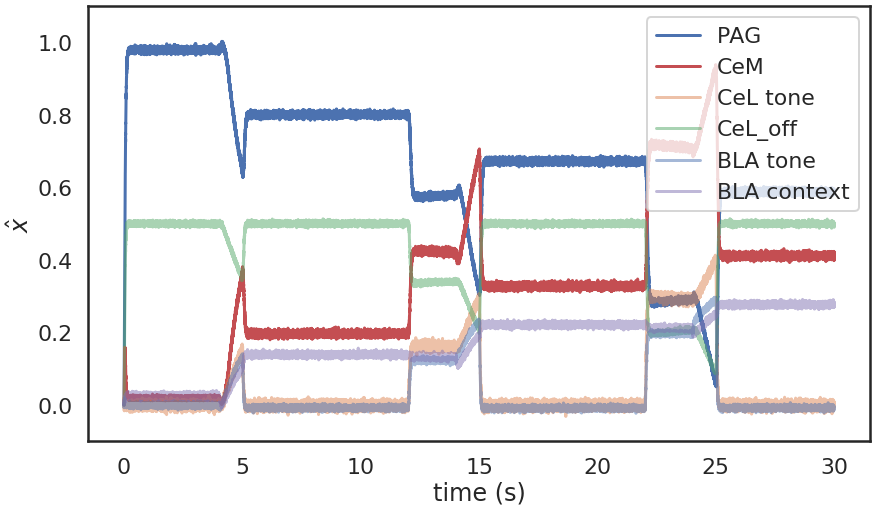

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

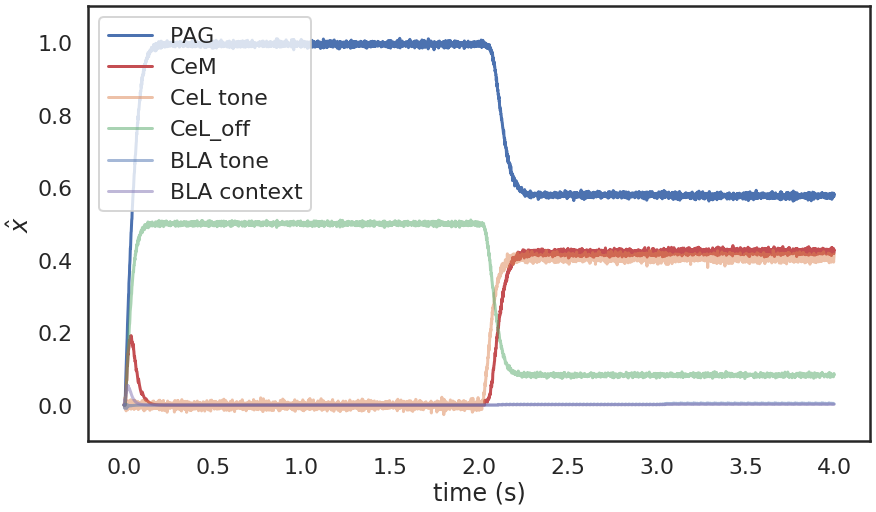

In [23]:
H = condition_muscimol_BLA()

## Hormones (Oxytocin, vasopressin, dopamine, seratonin)

### Applying oxytocin to CeL during conditioning does not affect learning (Viviani et al., 2011)

In [24]:
def oxytocin_CeL_condition(seed=0, plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    oxy_CeL_func = lambda t: -1

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, oxy_CeL_func=oxy_CeL_func,
        seed=seed)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/oxytocin_CeL_condition_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/oxytocin_CeL_condition_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

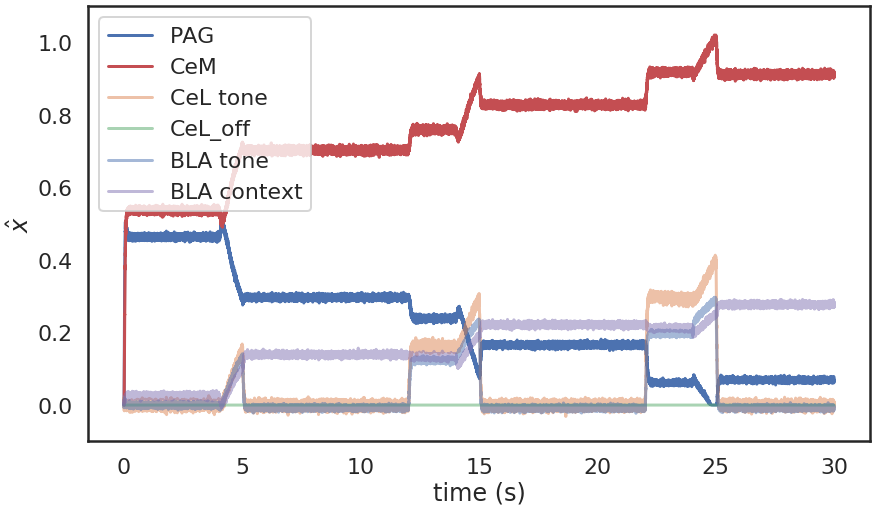

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

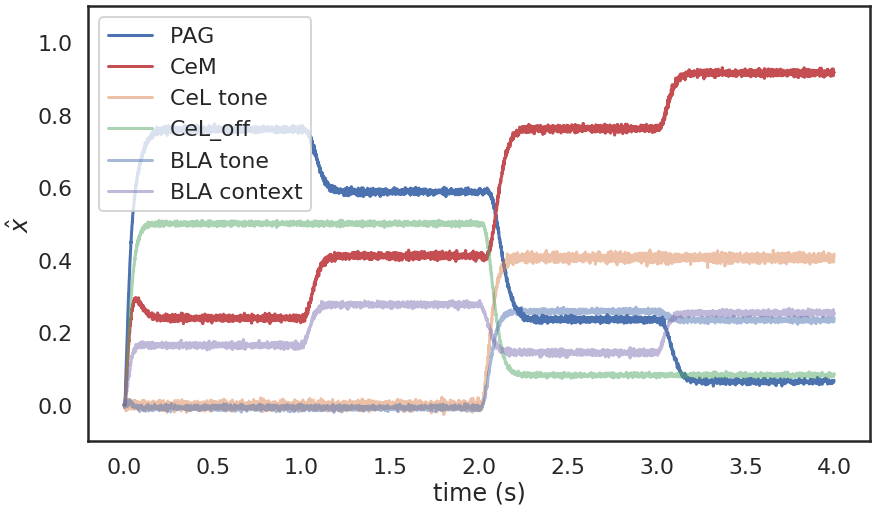

In [25]:
I = oxytocin_CeL_condition()

### Applying oxytocin during testing reduces fear expression (Viviani et al. 2011)

In [26]:
def condition_oxytocin_CeL(seed=0, plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/condition_oxytocin_CeL_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]
    oxy_CeL_func = lambda t: 1

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, oxy_CeL_func=oxy_CeL_func,
        seed=seed, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/condition_oxytocin_CeL_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

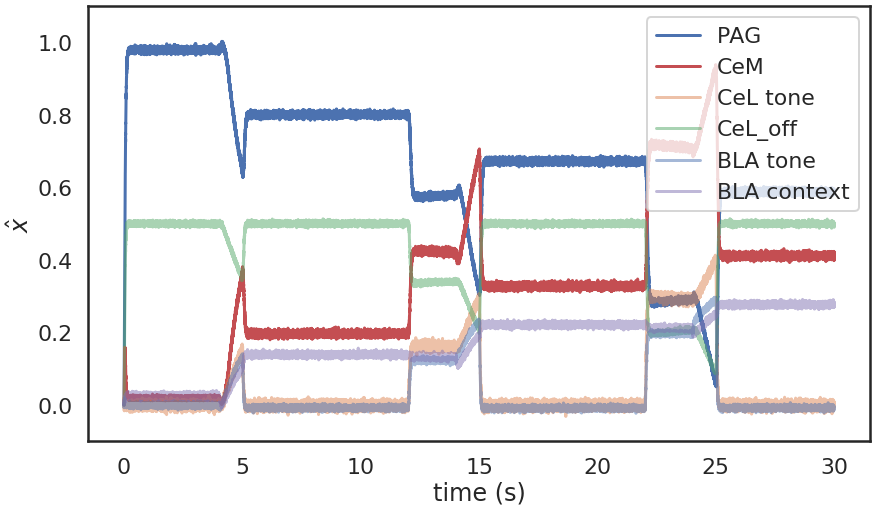

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

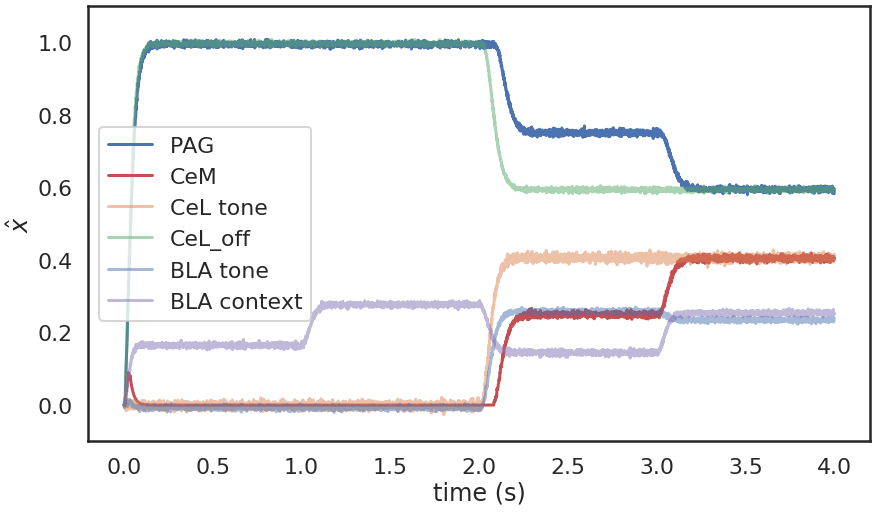

In [27]:
J = condition_oxytocin_CeL()

### Inactivation of GABAergic interneurons in BLA facilitates fear conditoning
Dopamine and Norepinephrine are natural neuromodulators of inhibition in BLA, and their presence is implicated in the aquisition of conditioned fear (Ehrlich et al., 2009)

In [28]:
def dopamine_BLA_condition(seed=0, plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    BLA_func = lambda t: 0

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, BLA_func=BLA_func,
        seed=seed)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/dopamine_BLA_condition_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/dopamine_BLA_condition_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

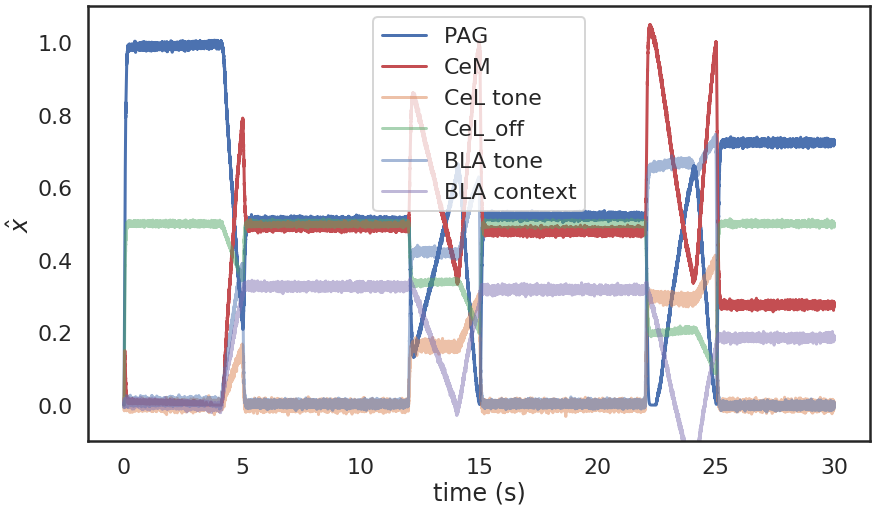

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

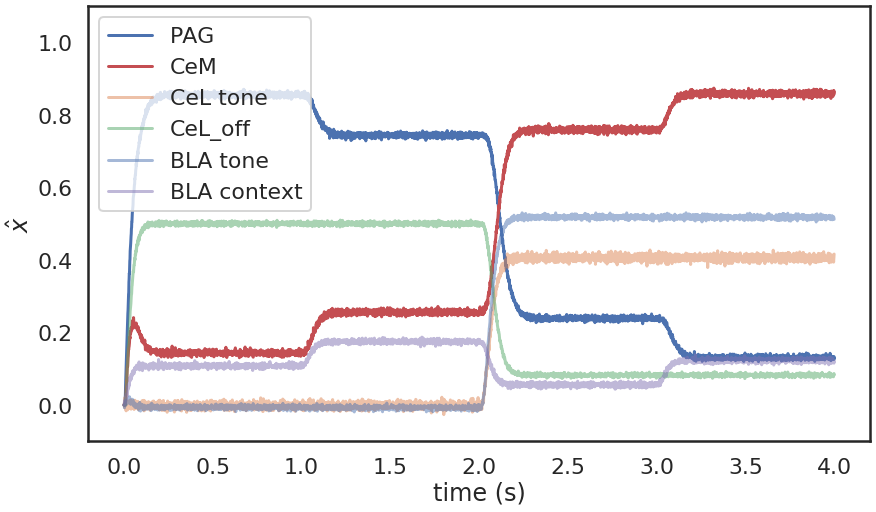

In [29]:
K = dopamine_BLA_condition()

### Activation of GABAergic interneurons in BLA impairs fear conditoning
Serotonin is a natural neuromodulators of inhibition in BLA, and its presence is implicated in constraining synaptic plasticity in LA (Ehrlich et al., 2009). 

In [30]:
def seratonin_BLA_condition(seed=0, plot=True):

    t_condition = 30
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    BLA_func = lambda t: 1.0

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, BLA_func=BLA_func,
        seed=seed)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/seratonin_BLA_condition_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func,
        seed=seed, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/seratonin_BLA_condition_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

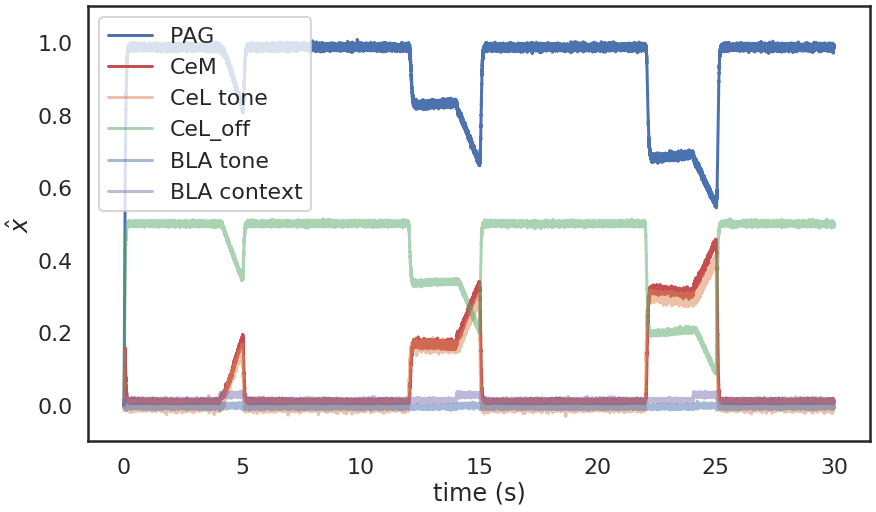

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

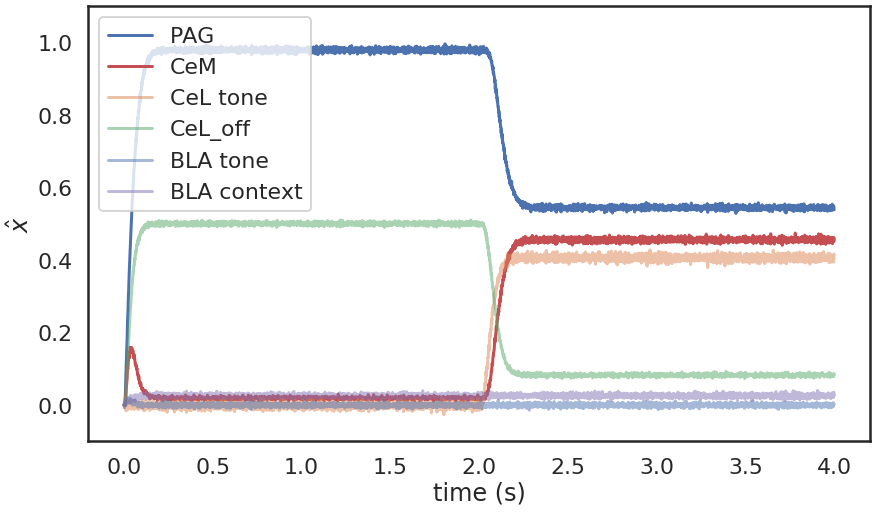

In [31]:
L = seratonin_BLA_condition()

## Misc

### Activation of CeM induces spontaneous freezing
Optogenetically activating CeM neurons elicits freezing (Ciocchi et al., 2010). Since CeM expresses vasopressin receptors (Huber et al. 2015), application of this neuropeptide should have a similar effect.

In [32]:
def vasopressin_CeM(seed=0, plot=True):

    t_test = 4
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]
    vaso_CeM_func = lambda t: 1.4

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, vaso_CeM_func=vaso_CeM_func,
        seed=seed, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(data['times'], data['PAG'], label='PAG', color=palette[0])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', alpha=0.5, color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', alpha=0.5, color=palette[2])
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', alpha=0.5, color=palette[0])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', alpha=0.5, color=palette[4])
        ax.set(xlabel='time (s)', ylabel='neural activity', ylim=((-0.1, 1.1)))
        ax.legend()
        plt.savefig('plots/vasopressin_CeM.svg')
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

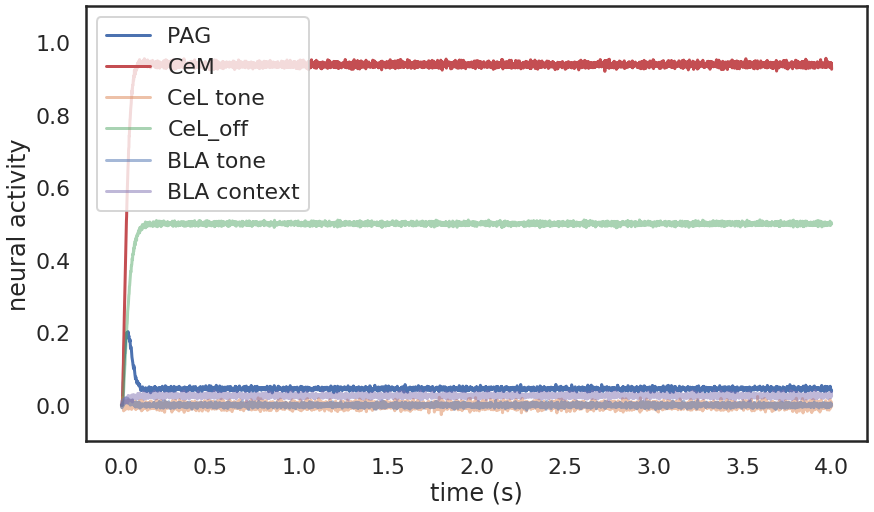

In [33]:
Z = vasopressin_CeM()

# Data Collection

In [41]:
n_trials = 10

As = np.array([pre_control(seed=n, plot=False) for n in range(n_trials)])
Bs = np.array([condition_control(seed=n, plot=False) for n in range(n_trials)])
Cs = np.array([extinction_control(seed=n, plot=False) for n in range(n_trials)])
Ds = np.array([pre_muscimol_CeL(seed=n, plot=False) for n in range(n_trials)])
Es = np.array([muscimol_CeL_condition(seed=n, plot=False) for n in range(n_trials)])
Fs = np.array([muscimol_BLA_condition(seed=n, plot=False) for n in range(n_trials)])
Gs = np.array([muscimol_BLA_extinction(seed=n, plot=False) for n in range(n_trials)])
Hs = np.array([condition_muscimol_BLA(seed=n, plot=False) for n in range(n_trials)])
Is = np.array([oxytocin_CeL_condition(seed=n, plot=False) for n in range(n_trials)])
Js = np.array([condition_oxytocin_CeL(seed=n, plot=False) for n in range(n_trials)])
Ks = np.array([dopamine_BLA_condition(seed=n, plot=False) for n in range(n_trials)])
Ls = np.array([seratonin_BLA_condition(seed=n, plot=False) for n in range(n_trials)])

np.savez('data.npz', As=As, Bs=Bs, Cs=Cs, Ds=Ds, Es=Es, Fs=Fs, Gs=Gs, Hs=Hs, Is=Is, Js=Js, Ks=Ks, Ls=Ls)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [42]:
import pandas as pd
columns = ['experiment', 'trial', 'neither', 'context', 'tone', 'both']
data = [As, Bs, Cs, Ds, Es, Fs, Gs, Hs, Is, Js, Ks, Ls]
names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
df = pd.DataFrame(columns=columns)
for exp in range(12):
    for n in range(n_trials):
        df = df.append(pd.DataFrame([[names[exp], n, data[exp][n][0], data[exp][n][1], data[exp][n][2], data[exp][n][3]]],
            columns=columns), ignore_index=True)

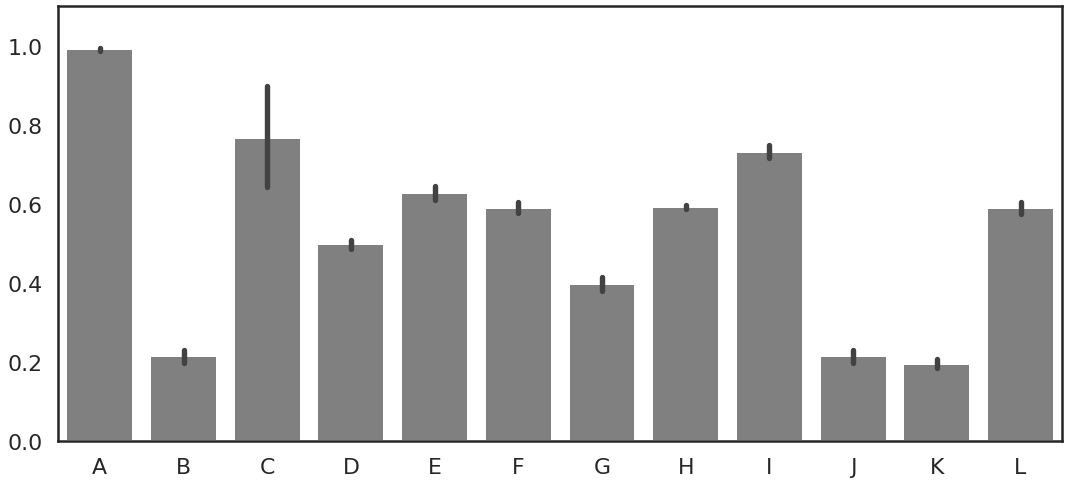

In [43]:
with sns.color_palette():
    fig, ax = plt.subplots(figsize=((18, 8)))
    sns.barplot(x='experiment', y='tone', ax=ax, data=df, color='gray')
    ax.set(ylim=((0, 1.1)), xlabel=None, ylabel=None)
    ax.set_xticklabels(names)
    plt.savefig('plots/results.svg')
    plt.show()